1.**New York Taxis: Predicting New York Taxis prices**

1.0.1 Goal and description

This data set consist of information related to taxi trips, prices, locations and more during a pedriod of time of almost 18 years. 

We are going study, investigate and make some research on the data in order to predict the prices of the trips and what are the most important features when predicting the price. In order to do this we are going to compare two methodologies, multiple linear regression model vs gradient boosting (xgboost).

This would be helpful for taxi drivers as they would be able to know how to improve their profitability, where are the locations where they can get best benefits and what is the best trip duration.

1.0.2 Step 1. Imports and loading datasets

In [1]:
# Import packages

# data manipulation packages
import numpy as np
import pandas as pd

# data visualization packages
from matplotlib import pyplot as plt
import seaborn as sns

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from scipy import stats

# For data modeling
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

import re #re module, which provides regular expression functionalities. Regular expressions are a powerful tool for searching and manipulating text based on patterns.

In [2]:
# Load dataset into a dataframe
taxi_df = pd.read_csv('Taxi_dataset.csv', low_memory=False)

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

In [3]:
taxi_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,01/01/2020 12:28:15 AM,01/01/2020 12:33:03 AM,1.0,1.2,1.0,N,238.0,239.0,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1,01/01/2020 12:35:39 AM,01/01/2020 12:43:04 AM,1.0,1.2,1.0,N,239.0,238.0,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1,01/01/2020 12:47:41 AM,01/01/2020 12:53:52 AM,1.0,0.6,1.0,N,238.0,238.0,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1,01/01/2020 12:55:23 AM,01/01/2020 01:00:14 AM,1.0,0.8,1.0,N,238.0,151.0,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2,01/01/2020 12:01:58 AM,01/01/2020 12:04:16 AM,1.0,0.0,1.0,N,193.0,193.0,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


1.0.3 Step 2. Data Exploration (Initial EDA and data cleaning)

In [4]:
taxi_df.shape

(11916667, 18)

As we can see using the shape function the data almost have 12 million rows. If there is a possibility of filtering the data and use less of it we will do it. In order to check this we will look at 'tpep_pickup_datetime' and 'tpep_dropoff_datetime' variables. 

In [5]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11916667 entries, 0 to 11916666
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               object 
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           float64
 8   DOLocationID           float64
 9   payment_type           float64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
dtypes: float64(14), object(4)
memory usage: 1.6+ GB


First thing we have encountered is that pickup and dropoff are not datetime type variables. In order to be able to work with them and filter the data we need to transform them into datetime variables.

In [6]:
taxi_df['tpep_pickup_datetime'].head()

0    01/01/2020 12:28:15 AM
1    01/01/2020 12:35:39 AM
2    01/01/2020 12:47:41 AM
3    01/01/2020 12:55:23 AM
4    01/01/2020 12:01:58 AM
Name: tpep_pickup_datetime, dtype: object

In order to transform the variable into datetime we need to know what is the string format. Using head() we saw that we were not able to see if first and second position of the string corresponded to days or months and what type of hour clock the data set is using. By using iloc[ ] and selecting a random number we can now see what is the string format used in the data set.

In [7]:
taxi_df['tpep_pickup_datetime'].iloc[5000000]

'01/25/2020 06:04:12 PM'

In [8]:
# Assuming most data follows MM/DD/YYYY HH:MM:SS format
format_string = '%m/%d/%Y %I:%M:%S %p'

# Convert columns to datetime with specified format
taxi_df['tpep_pickup_datetime'] = pd.to_datetime(taxi_df['tpep_pickup_datetime'], format=format_string)
taxi_df['tpep_dropoff_datetime'] = pd.to_datetime(taxi_df['tpep_dropoff_datetime'], format=format_string)

In [9]:
# checking dtype and transformation
print(taxi_df['tpep_pickup_datetime'].dtype)
print(taxi_df['tpep_dropoff_datetime'].dtype)
print(taxi_df['tpep_pickup_datetime'].head())

datetime64[ns]
datetime64[ns]
0   2020-01-01 00:28:15
1   2020-01-01 00:35:39
2   2020-01-01 00:47:41
3   2020-01-01 00:55:23
4   2020-01-01 00:01:58
Name: tpep_pickup_datetime, dtype: datetime64[ns]


Now, we are going to check what is the minimun and maximun value for each variable. Why doing this? As said previously we are going to filter if possible as the data set is really large. With this approach we can easily see what how many years the dataset have.

In [10]:
print()
print('Pickup datetime')
print(taxi_df['tpep_pickup_datetime'].min())
print(taxi_df['tpep_pickup_datetime'].max())
print()
print('Dropoff datetime')
print(taxi_df['tpep_dropoff_datetime'].min())
print(taxi_df['tpep_dropoff_datetime'].max())


Pickup datetime
2003-01-01 00:07:17
2021-01-02 01:12:10

Dropoff datetime
2003-01-01 14:16:59
2021-01-02 01:25:01


As a first look we can see that data is splitted from year 2003 to 2021. 18 years of data is a lot. We will take a deeper look to see how data is splitted.

In [11]:
taxi_df['tpep_pickup_year'] = taxi_df['tpep_pickup_datetime'].dt.year
taxi_df['tpep_pickup_year']

0           2020.0
1           2020.0
2           2020.0
3           2020.0
4           2020.0
             ...  
11916662       NaN
11916663       NaN
11916664       NaN
11916665       NaN
11916666       NaN
Name: tpep_pickup_year, Length: 11916667, dtype: float64

We have created a new column called 'tpep_pickup_year' so we can split the data better but we saw that data has NaN and the year is represented as float. In order to get year as int we have to use astype(int) but having NaN we would encounter and error.

Before further filtering in the datetime we are going to see how much data is missing and we will take a decision on wether or not to drop it just in the datetime column or in the entire dataset.

In [12]:
#checking for missing data
taxi_df.isna().sum()

VendorID                 91448
tpep_pickup_datetime         5
tpep_dropoff_datetime        5
passenger_count          91453
trip_distance                5
RatecodeID               91453
store_and_fwd_flag       91453
PULocationID                 5
DOLocationID                 5
payment_type             91453
fare_amount                  5
extra                        5
mta_tax                      5
tip_amount                   5
tolls_amount                 5
improvement_surcharge        5
total_amount                 5
congestion_surcharge         5
tpep_pickup_year             5
dtype: int64

There are 91453 missing values in some of the columns. Taking into account that we are dealing with almos twelve million rows we have decided to drop them as they only represent 0.76% of the total data set.

*We now that missing values should be taken into account when cleaning data for the different machine learning models and analysis that may be created but in order to be able to work easily and seeing such a low percentage we believe is a good decision to drop them.*

In [13]:
# dropping missing values
taxi_df = taxi_df.dropna()
# checking missing values after dropping them
taxi_df.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
tpep_pickup_year         0
dtype: int64

Now we can proceed and continue working with datetime variables.

In [14]:
# transforming year into integer
taxi_df['tpep_pickup_year'] = taxi_df['tpep_pickup_year'].astype(int)
taxi_df['tpep_pickup_year'].head()

0    2020
1    2020
2    2020
3    2020
4    2020
Name: tpep_pickup_year, dtype: int32

Next step is to see how data is splitted.

In [15]:
taxi_df.groupby('tpep_pickup_year')['tpep_pickup_year'].size()

tpep_pickup_year
2003           1
2008          16
2009          40
2019         131
2020    11825023
2021           3
Name: tpep_pickup_year, dtype: int64

We have achieved a really good insigth as most of the data is from 2020. As the rest of the years are not significant we will just work with 2020 data.

As we are going to work with 2020 data but we have not yet finish cleaning and structuring the data we are going to keep working on the data and when it is cleaned as desired we will filter for year 2020.

In [16]:
# Passenger count to integer
taxi_df['passenger_count'] = taxi_df['passenger_count'].astype(int)
print('Passenger count dtype: ', taxi_df['passenger_count'].dtype)
# RatecodeID represents the final rate code in effect at the end of the trip
taxi_df['RatecodeID'] = taxi_df['RatecodeID'].astype(int)
print('RatecodeID dtype: ', taxi_df['RatecodeID'].dtype)
# PULocationID and DOLocationID to integers (pickup and dropoff location)
taxi_df['PULocationID'] = taxi_df['PULocationID'].astype(int)
taxi_df['DOLocationID'] = taxi_df['DOLocationID'].astype(int)
print('Pickup dtype: ', taxi_df['PULocationID'].dtype)
print('Dropoff dtype: ', taxi_df['DOLocationID'].dtype)
# Payment type to integers (A numeric code signifying how the passenger paid for the trip.)
taxi_df['payment_type'] = taxi_df['payment_type'].astype(int)
print('Payment type: ', taxi_df['payment_type'].dtype)

Passenger count dtype:  int32
RatecodeID dtype:  int32
Pickup dtype:  int32
Dropoff dtype:  int32
Payment type:  int32


In [17]:
taxi_df.dtypes

VendorID                         object
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int32
trip_distance                   float64
RatecodeID                        int32
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int32
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
tpep_pickup_year                  int32
dtype: object

In [18]:
# Checking for duplicates
taxi_df.duplicated().sum()

0

We have finished first part of EDA (Initial EDA and data cleaning). From here we can start working on our analysis with a good base and knowledge of how the data is structure and formated. 

Now we will filter the data to 2020.

In [19]:
# We create a new filtered dataframe selecting year 2020
taxi_filtered_df = taxi_df[taxi_df['tpep_pickup_year']==2020]

In [20]:
# We can reuse the code from above and check if the dataframe was succesfully filtered.
taxi_filtered_df.groupby('tpep_pickup_year')['tpep_pickup_year'].size()

tpep_pickup_year
2020    11825023
Name: tpep_pickup_year, dtype: int64

In [21]:
taxi_filtered_df.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,tpep_pickup_year
count,11825023,11825023,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,1.182502e+07,11825023.0
mean,2020-01-30 01:23:28.626809600,2020-01-30 01:39:23.017398528,1.510425e+00,2.824260e+00,1.058356e+00,1.649607e+02,1.629489e+02,1.265057e+00,1.248276e+01,1.096072e+00,4.938125e-01,2.223564e+00,3.282526e-01,2.979414e-01,1.846652e+01,2.302985e+00,2020.0
min,2020-01-01 00:00:00,2020-01-01 00:01:17,0.000000e+00,-2.218000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.238000e+03,-2.700000e+01,-5.000000e-01,-9.300000e+01,-3.823000e+01,-3.000000e-01,-1.242300e+03,-2.500000e+00,2020.0
25%,2020-01-16 07:57:06.500000,2020-01-16 08:11:34.500000,1.000000e+00,9.600000e-01,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.116000e+01,2.500000e+00,2020.0
50%,2020-01-30 09:33:42,2020-01-30 09:50:32,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,1.960000e+00,0.000000e+00,3.000000e-01,1.430000e+01,2.500000e+00,2020.0
75%,2020-02-12 19:14:56.500000,2020-02-12 19:29:40,2.000000e+00,2.880000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.350000e+01,2.500000e+00,5.000000e-01,2.940000e+00,0.000000e+00,3.000000e-01,1.975000e+01,2.500000e+00,2020.0
max,2020-07-31 18:50:41,2020-07-31 18:54:12,9.000000e+00,3.699400e+02,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,4.265000e+03,1.130100e+02,3.951000e+01,1.100000e+03,9.255000e+02,3.000000e-01,4.268300e+03,2.750000e+00,2020.0
std,NaN,NaN,1.148948e+00,3.710346e+00,7.988824e-01,6.537098e+01,6.970159e+01,4.715760e-01,1.176840e+01,1.251105e+00,6.954457e-02,2.719858e+00,1.714911e+00,3.427594e-02,1.443884e+01,6.962740e-01,0.0


From this first view of the data that we are going to work we can infer some basic insights.
- Data range goes from Jan 1st 2020 to July 31st. We will build our conclusions and models based on 7 months data.
- Passenger count goes from 0 to 9 passenger. For those with 0 passenger we will have to take o better look as it migth by people that finally cancel the trip. We will also look at the total amount charge and the amount of rows in order to decide what to do with them.
- Trip distance has negative values that should not be possible. We will handle those values. Maximum trip distance is 369 miles. A taxi trip for such a distance is really long. We may see outliers here.
- All variables related to the amount charge to the customer have also negative values and really high values. We will investigate it and make sure if data is available to work with it.

In [22]:
# Checking possible misleading data from variables
# 1. Number of passenger = 0
print('Number of entries with 0 passengers: ', taxi_filtered_df[taxi_filtered_df['passenger_count']==0].count()['passenger_count'])
taxi_filtered_df[taxi_filtered_df['passenger_count']==0][['passenger_count','total_amount']]

Number of entries with 0 passengers:  222229


,passenger_count,total_amount
263,0,13.55
264,0,14.15
265,0,15.30
280,0,20.92
282,0,18.35
...,...,...
11916575,0,12.35
11916576,0,15.30
11916598,0,10.55
11916599,0,9.95


In [23]:
taxi_filtered_df[taxi_filtered_df['passenger_count']==0][['total_amount']].value_counts()

total_amount
9.30            4589
10.30           4551
9.80            4549
10.80           4498
8.80            4226
                ... 
45.85              1
45.60              1
45.56              1
45.43              1
435.42             1
Name: count, Length: 3142, dtype: int64

In [24]:
# Quick check on for passenger = 0 in time difference by trip.
taxi_filtered_df[taxi_filtered_df['passenger_count']==0][['passenger_count','tpep_pickup_datetime','tpep_dropoff_datetime']]

,passenger_count,tpep_pickup_datetime,tpep_dropoff_datetime
263,0,2020-01-01 00:30:01,2020-01-01 00:39:06
264,0,2020-01-01 00:40:50,2020-01-01 00:50:05
265,0,2020-01-01 00:54:17,2020-01-01 01:08:08
280,0,2020-01-01 00:34:58,2020-01-01 00:45:28
282,0,2020-01-01 00:55:25,2020-01-01 01:10:34
...,...,...,...
11916575,0,2020-02-26 21:01:49,2020-02-26 21:07:32
11916576,0,2020-02-26 21:31:44,2020-02-26 21:46:39
11916598,0,2020-02-26 21:13:19,2020-02-26 21:18:10
11916599,0,2020-02-26 21:22:13,2020-02-26 21:24:24


In [25]:
# creating a new column with the difference in time by trip
taxi_filtered_df.loc[:, 'dif_pickup_dropoff_mins'] = (taxi_filtered_df['tpep_dropoff_datetime'] - taxi_filtered_df['tpep_pickup_datetime']) / pd.Timedelta(minutes=1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9620\2346945767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_filtered_df.loc[:, 'dif_pickup_dropoff_mins'] = (taxi_filtered_df['tpep_dropoff_datetime'] - taxi_filtered_df['tpep_pickup_datetime']) / pd.Timedelta(minutes=1)


In [26]:
# Creating a boxplot to visualize how data is structure that will help on future data decisions.
# First we create a dataframe with passenger = 0
no_passenger_df= taxi_filtered_df[taxi_filtered_df['passenger_count']==0]
# Second looking at main stats with describe method
no_passenger_df['dif_pickup_dropoff_mins'].describe()

count    222229.000000
mean         12.675167
std          13.866527
min           0.000000
25%           6.033333
50%          10.083333
75%          16.250000
max        1439.366667
Name: dif_pickup_dropoff_mins, dtype: float64

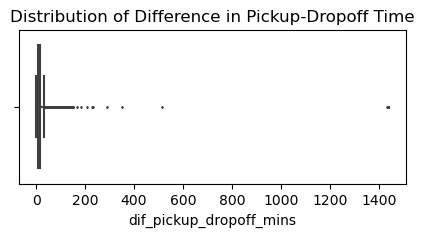

In [27]:
plt.figure(figsize=(5,2))
sns.boxplot(x=no_passenger_df['dif_pickup_dropoff_mins'], fliersize = 1)
plt.title('Distribution of Difference in Pickup-Dropoff Time')
plt.show()

In [28]:
taxi_filtered_df['passenger_count'].value_counts()

passenger_count
1    8494328
2    1757979
3     461673
5     418225
6     245808
4     224672
0     222229
7         51
8         32
9         26
Name: count, dtype: int64

In [29]:
no_passenger_df.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,tpep_pickup_year,dif_pickup_dropoff_mins
count,222229,222229,222229.0,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.000000,222229.0,222229.000000
mean,2020-01-30 20:40:35.254732800,2020-01-30 20:53:15.764751616,0.0,2.639580,1.134154,165.118108,163.276112,1.290412,12.131895,2.624917,0.495576,2.127231,0.298035,0.299707,17.982164,2.301162,2020.0,12.675167
min,2020-01-01 00:00:05,2020-01-01 00:09:20,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,-225.500000,0.000000,-0.500000,0.000000,0.000000,-0.300000,-228.800000,-2.500000,2020.0,0.000000
25%,2020-01-16 22:52:40,2020-01-16 23:05:26,0.0,0.900000,1.000000,132.000000,113.000000,1.000000,6.000000,2.500000,0.500000,0.000000,0.000000,0.300000,10.800000,2.500000,2020.0,6.033333
50%,2020-01-31 10:15:17,2020-01-31 10:30:00,0.0,1.500000,1.000000,162.000000,162.000000,1.000000,8.500000,2.500000,0.500000,1.850000,0.000000,0.300000,14.100000,2.500000,2020.0,10.083333
75%,2020-02-13 14:37:12,2020-02-13 14:51:07,0.0,2.700000,1.000000,234.000000,234.000000,2.000000,13.000000,3.000000,0.500000,2.780000,0.000000,0.300000,18.960000,2.500000,2020.0,16.250000
max,2020-07-28 09:02:59,2020-07-28 09:08:19,0.0,93.500000,99.000000,265.000000,265.000000,4.000000,428.500000,7.000000,3.300000,309.730000,93.500000,0.300000,435.420000,2.500000,2020.0,1439.366667
std,NaN,NaN,0.0,3.550434,2.597158,64.936563,69.206114,0.520903,11.386968,0.836462,0.050319,2.791150,1.569106,0.010395,13.834174,0.677014,0.0,13.866527


There are 222229 rows that are filled with zero passenger in a trip. This represents 1.87% of the total data set.
We have look for possible patterns in the data that could explain this casuistic.
First we looked at the total amount charged to customers and we saw that there is not a usual amount charged. We also looked at the trip time as we thought we could see patterns in the hours or the minutes per trip. It is true that the average trip is around 12.5 minutes (short trips in a city like New York) but invesitigating other variables we did not see a direct connection.
We also visualize how data was distributed as we could saw possible outliers and data that might not be correctly inputed in the data set. 

Taking into account this analysis and the possible explanations of having trips with zero passengers (cancelled trips, forgotten items, very short trips, etc.) we have decided to drop the rows with  zero passengers.

For the future purposes of the analysis we think it would lead to more inneficient results than efficieint.

In [30]:
# dropping passenger count = 0 from the dataframe
taxi_filtered_df = taxi_filtered_df[taxi_filtered_df['passenger_count'] != 0]

In [31]:
# checking if passenger count = 0 was succesfully dropped
taxi_filtered_df['passenger_count'].value_counts()

passenger_count
1    8494328
2    1757979
3     461673
5     418225
6     245808
4     224672
7         51
8         32
9         26
Name: count, dtype: int64

In [32]:
taxi_filtered_df.describe(include='all')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,tpep_pickup_year,dif_pickup_dropoff_mins
count,11602794,11602794,11602794,1.160279e+07,1.160279e+07,1.160279e+07,11602794,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,1.160279e+07,11602794.0,1.160279e+07
unique,2,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,7923662,NaN,NaN,NaN,NaN,NaN,11486670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2020-01-30 01:01:18.894498304,2020-01-30 01:17:16.998491904,1.539354e+00,2.827798e+00,1.056904e+00,NaN,1.649577e+02,1.629427e+02,1.264571e+00,1.248948e+01,1.066790e+00,4.937787e-01,2.225409e+00,3.288314e-01,2.979076e-01,1.847580e+01,2.303020e+00,2020.0,1.596840e+01
min,NaN,2020-01-01 00:00:00,2020-01-01 00:01:17,1.000000e+00,-2.218000e+01,1.000000e+00,NaN,1.000000e+00,1.000000e+00,1.000000e+00,-1.238000e+03,-2.700000e+01,-5.000000e-01,-9.300000e+01,-3.823000e+01,-3.000000e-01,-1.242300e+03,-2.500000e+00,2020.0,-9.990667e+03
25%,NaN,2020-01-16 07:39:06,2020-01-16 07:53:20,1.000000e+00,9.600000e-01,1.000000e+00,NaN,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.116000e+01,2.500000e+00,2020.0,6.433333e+00
50%,NaN,2020-01-30 09:10:56,2020-01-30 09:27:53,1.000000e+00,1.600000e+00,1.000000e+00,NaN,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,1.960000e+00,0.000000e+00,3.000000e-01,1.430000e+01,2.500000e+00,2020.0,1.056667e+01
75%,NaN,2020-02-12 19:02:18,2020-02-12 19:17:24,2.000000e+00,2.890000e+00,1.000000e+00,NaN,2.340000e+02,2.340000e+02,2.000000e+00,1.350000e+01,2.500000e+00,5.000000e-01,2.940000e+00,0.000000e+00,3.000000e-01,1.975000e+01,2.500000e+00,2020.0,1.690000e+01
max,NaN,2020-07-31 18:50:41,2020-07-31 18:54:12,9.000000e+00,3.699400e+02,9.900000e+01,NaN,2.650000e+02,2.650000e+02,5.000000e+00,4.265000e+03,1.130100e+02,3.951000e+01,1.100000e+03,9.255000e+02,3.000000e-01,4.268300e+03,2.750000e+00,2020.0,8.525117e+03


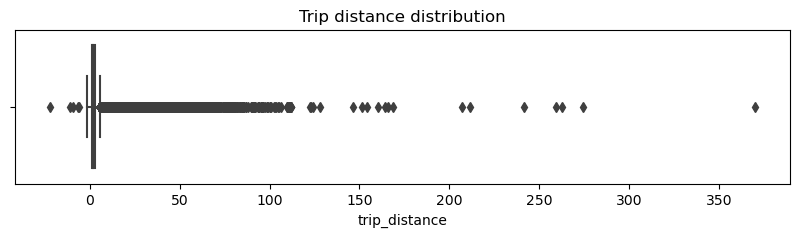

In [33]:
# 2. Trip distance
# Visualizing distribution
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['trip_distance'])
plt.title('Trip distance distribution')
plt.show()

As shown in the boxplot we have negative values and outliers. 

Negative trip distances does not make sense so we will drop them from the data. Later we will handle outliers.

In [34]:
# Handling negative values
negative_trip_distance_df = taxi_filtered_df[taxi_filtered_df['trip_distance']< 0]

In [35]:
negative_trip_distance_df['trip_distance'].value_counts()

trip_distance
-0.88     2
-0.71     1
-9.29     1
-1.79     1
-22.18    1
-1.25     1
-1.32     1
-1.48     1
-6.33     1
-10.94    1
-1.44     1
-6.40     1
Name: count, dtype: int64

In [36]:
negative_trip_distance_df['trip_distance'].count().sum()

13

In [37]:
# Dropping values trip_distance < 0 
taxi_filtered_df = taxi_filtered_df[taxi_filtered_df['trip_distance']>=0]
# Checking that values are successfully dropped
taxi_filtered_df[taxi_filtered_df['trip_distance']< 0].count().sum()

0

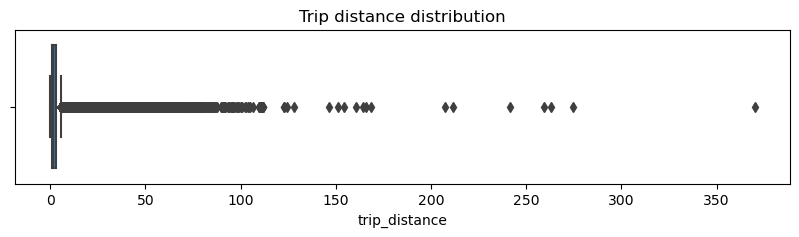

In [38]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['trip_distance'])
plt.title('Trip distance distribution')
plt.show()

In [39]:
taxi_filtered_df.groupby('trip_distance')['trip_distance'].count()

trip_distance
0.00      117074
0.01        6429
0.02        4615
0.03        3659
0.04        2932
           ...  
241.64         1
259.22         1
262.88         1
274.50         1
369.94         1
Name: trip_distance, Length: 4995, dtype: int64

We can observ that there are trip distances equal to zero or very near. As there are still some varibles we want to clean that can be connected with trip distance we are not going to do anything but after checking all the variables we will review the number and see if we need to put a threshold and drop some values. 

We have decided to take this decision as it may happen that some trips are cancelled but still charged to the customer for example and it's a really low amount of occurencies from all the data.

In [40]:
# handling outliers (long distances)
# We are going to handle outliers taking into consideration what is academically considered an outlier 1.5+-IQR.
# We could have put a threshold but as data seems not official we prefer to go for an academic approach.


# quantile 0.25
percentile_25 = taxi_filtered_df['trip_distance'].quantile(0.25)
print('Percintile 25%: ', percentile_25)

# quantile 0.75
percentile_75 = taxi_filtered_df['trip_distance'].quantile(0.75)
print('Percintile 75%: ', percentile_75)

# IQR 
iqr = round(percentile_75 - percentile_25, 2) 
print('IQR: ', iqr)

# upper limit
upper_limit = percentile_75 + 1.5 * iqr
print('Upper limit: ', upper_limit)

# defining outliers in taxi_filtered_df
outliers = taxi_filtered_df[taxi_filtered_df['trip_distance']> upper_limit]


Percintile 25%:  0.96
Percintile 75%:  2.89
IQR:  1.93
Upper limit:  5.785


Knowing this values and having identified outliers it would be interesting to see how many of this
outliers we do have in the data set. Pulling how many rows we can see the impact of this outliers.

In [41]:
# pulling outliers rows
print('# of rows with outliers in trip distance:', len(outliers))
print()
print(f'% of outliers in trip distance against total: {round(len(outliers)/len(taxi_filtered_df)*100, 2)}%')

# of rows with outliers in trip distance: 1282763

% of outliers in trip distance against total: 11.06%


Upper limit is 5.785 miles and that's what we are going to use even if it implies dropping 11% of the data. We want to predict how much the total amount will be depedending on different features and as the data is large that quantity of rows should not be a problem.

In [42]:
taxi_filtered_df = taxi_filtered_df[taxi_filtered_df['trip_distance'] <= upper_limit]

In [43]:
taxi_filtered_df.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,tpep_pickup_year,dif_pickup_dropoff_mins
count,10320018,10320018,1.032002e+07,1.032002e+07,1.032002e+07,1.032002e+07,1.032002e+07,1.032002e+07,1.032002e+07,1.032002e+07,1.032002e+07,1.032002e+07,1.032002e+07,1.032002e+07,1.032002e+07,1.032002e+07,10320018.0,1.032002e+07
mean,2020-01-30 02:10:51.116020992,2020-01-30 02:24:21.002189056,1.537818e+00,1.743716e+00,1.027067e+00,1.669801e+02,1.654240e+02,1.263886e+00,9.562894e+00,1.075104e+00,4.948194e-01,1.797637e+00,2.973793e-02,2.978415e-01,1.486134e+01,2.354250e+00,2020.0,1.349810e+01
min,2020-01-01 00:00:00,2020-01-01 00:01:17,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-7.500000e+02,-2.700000e+01,-5.000000e-01,-9.300000e+01,-3.574000e+01,-3.000000e-01,-7.503000e+02,-2.500000e+00,2020.0,-2.860967e+03
25%,2020-01-16 09:15:53,2020-01-16 09:31:24.249999872,1.000000e+00,9.000000e-01,1.000000e+00,1.250000e+02,1.140000e+02,1.000000e+00,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.080000e+01,2.500000e+00,2020.0,6.016667e+00
50%,2020-01-30 10:16:13,2020-01-30 10:31:23,1.000000e+00,1.420000e+00,1.000000e+00,1.630000e+02,1.630000e+02,1.000000e+00,8.500000e+00,5.000000e-01,5.000000e-01,1.860000e+00,0.000000e+00,3.000000e-01,1.356000e+01,2.500000e+00,2020.0,9.566667e+00
75%,2020-02-12 18:43:23.750000128,2020-02-12 18:56:42,2.000000e+00,2.300000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.150000e+01,2.500000e+00,5.000000e-01,2.660000e+00,0.000000e+00,3.000000e-01,1.730000e+01,2.500000e+00,2020.0,1.440000e+01
max,2020-07-31 18:50:41,2020-07-31 18:54:12,9.000000e+00,5.780000e+00,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,4.265000e+03,1.130100e+02,3.951000e+01,1.100000e+03,9.255000e+02,3.000000e-01,4.268300e+03,2.750000e+00,2020.0,8.525117e+03
std,NaN,NaN,1.140253e+00,1.169619e+00,7.020182e-01,6.612715e+01,6.869151e+01,4.695245e-01,6.741937e+00,1.221553e+00,6.672115e-02,1.829724e+00,7.312288e-01,3.511367e-02,7.840977e+00,6.137729e-01,0.0,6.059831e+01


After cleaning the data from trip distance we have all the features related to the amount charge to the customers. All of them from fare amount to total amount have negative values. 

Those numbers does not make sense also so we are going to dropp them from the dataframe. To begin with, we will drop total amount negative values as it is the total and it is connected to the others.

In [44]:
# Checking what are the negative values
taxi_filtered_df[taxi_filtered_df['total_amount']<0]['total_amount'].value_counts()

total_amount
-8.30      2402
-7.80      2281
-8.80      2244
-6.80      2128
-7.30      2052
           ... 
-17.28        1
-214.30       1
-38.90        1
-49.60        1
-50.74        1
Name: count, Length: 551, dtype: int64

In [45]:
# Checking how  many rows
taxi_filtered_df[taxi_filtered_df['total_amount']<0]['total_amount'].count().sum()

33839

In [46]:
taxi_filtered_df = taxi_filtered_df[taxi_filtered_df['total_amount']>=0]

In [47]:
taxi_filtered_df[taxi_filtered_df['fare_amount']<0]['fare_amount'].count().sum()

3

In [48]:
taxi_filtered_df = taxi_filtered_df[taxi_filtered_df['fare_amount']>=0]

In [49]:
taxi_filtered_df[taxi_filtered_df['extra']<0]['extra'].count().sum()

3

In [50]:
taxi_filtered_df = taxi_filtered_df[taxi_filtered_df['extra']>=0]

In [51]:
taxi_filtered_df[taxi_filtered_df['tolls_amount']<0]['tolls_amount'].count().sum()

1

In [52]:
taxi_filtered_df = taxi_filtered_df[taxi_filtered_df['tolls_amount']>=0]

In [53]:
taxi_filtered_df.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,tpep_pickup_year,dif_pickup_dropoff_mins
count,10286172,10286172,1.028617e+07,1.028617e+07,1.028617e+07,1.028617e+07,1.028617e+07,1.028617e+07,1.028617e+07,1.028617e+07,1.028617e+07,1.028617e+07,1.028617e+07,1.028617e+07,1.028617e+07,1.028617e+07,10286172.0,1.028617e+07
mean,2020-01-30 02:10:20.175095552,2020-01-30 02:23:51.044186624,1.538071e+00,1.746383e+00,1.026634e+00,1.669937e+02,1.654343e+02,1.257253e+00,9.627847e+00,1.079821e+00,4.980517e-01,1.803526e+00,2.995886e-02,2.998082e-01,1.495434e+01,2.368737e+00,2020.0,1.351448e+01
min,2020-01-01 00:00:00,2020-01-01 00:01:17,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2020.0,-2.860967e+03
25%,2020-01-16 09:15:16,2020-01-16 09:30:34,1.000000e+00,9.000000e-01,1.000000e+00,1.250000e+02,1.140000e+02,1.000000e+00,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.080000e+01,2.500000e+00,2020.0,6.033333e+00
50%,2020-01-30 10:15:01,2020-01-30 10:30:20,1.000000e+00,1.420000e+00,1.000000e+00,1.630000e+02,1.630000e+02,1.000000e+00,8.500000e+00,5.000000e-01,5.000000e-01,1.860000e+00,0.000000e+00,3.000000e-01,1.356000e+01,2.500000e+00,2020.0,9.583333e+00
75%,2020-02-12 18:42:00,2020-02-12 18:55:09,2.000000e+00,2.300000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.150000e+01,2.500000e+00,5.000000e-01,2.660000e+00,0.000000e+00,3.000000e-01,1.730000e+01,2.500000e+00,2020.0,1.441667e+01
max,2020-07-31 18:50:41,2020-07-31 18:54:12,9.000000e+00,5.780000e+00,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,4.265000e+03,1.130100e+02,3.951000e+01,1.100000e+03,9.255000e+02,3.000000e-01,4.268300e+03,2.750000e+00,2020.0,8.525117e+03
std,NaN,NaN,1.140657e+00,1.168710e+00,7.015932e-01,6.612391e+01,6.868860e+01,4.538067e-01,6.521068e+00,1.220316e+00,3.358274e-02,1.828900e+00,7.316718e-01,7.583495e-03,7.565987e+00,5.576027e-01,0.0,6.059891e+01


In [54]:
print('Min fare amount :' , taxi_filtered_df['fare_amount'].min())
print('Max fare amount :' , taxi_filtered_df['fare_amount'].max())
print()
print('Min extra :' , taxi_filtered_df['extra'].min())
print('Max extra :' ,taxi_filtered_df['extra'].max())
print()
print('Min mta tax :' , taxi_filtered_df['mta_tax'].min())
print('Max mta tax :' ,taxi_filtered_df['mta_tax'].max())
print()
print('Min tip amount :' , taxi_filtered_df['tip_amount'].min())
print('Max tip amount :' ,taxi_filtered_df['tip_amount'].max())
print()
print('Min tolls amount :' , taxi_filtered_df['tolls_amount'].min())
print('Max tolls amount :' ,taxi_filtered_df['tolls_amount'].max())
print()
print('Min total amount :' , taxi_filtered_df['total_amount'].min())
print('Max total amount :' ,taxi_filtered_df['total_amount'].max())
print()

Min fare amount : 0.0
Max fare amount : 4265.0

Min extra : 0.0
Max extra : 113.01

Min mta tax : 0.0
Max mta tax : 39.51

Min tip amount : 0.0
Max tip amount : 1100.0

Min tolls amount : 0.0
Max tolls amount : 925.5

Min total amount : 0.0
Max total amount : 4268.3



In order to decide what to do with the outliers, we are going to visualize the distribution.

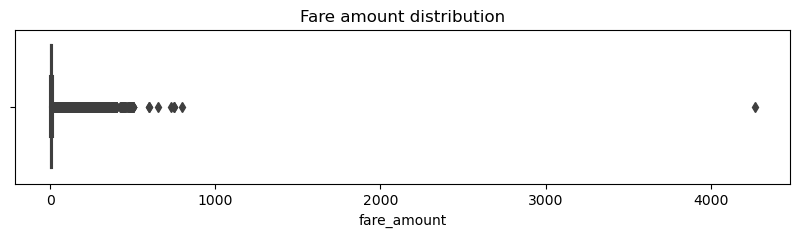

In [55]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['fare_amount'])
plt.title('Fare amount distribution')
plt.show()

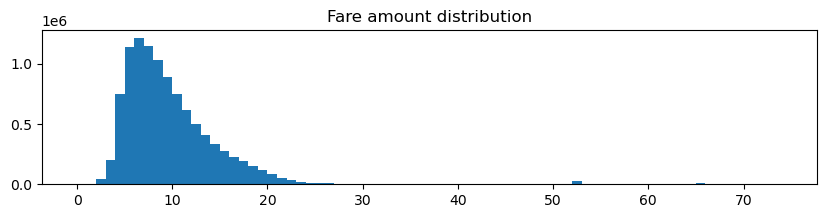

In [56]:
plt.figure(figsize=(10,2))
plt.hist(taxi_filtered_df['fare_amount'], bins=range(0,75))
plt.title('Fare amount distribution')
plt.show()

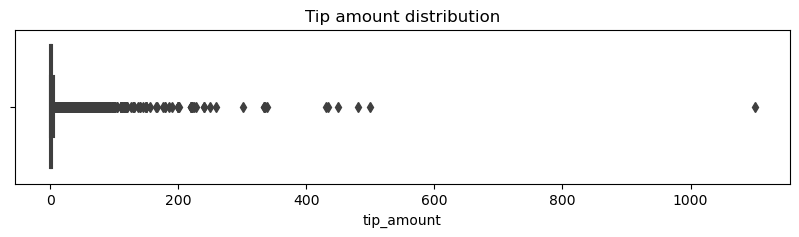

In [57]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['tip_amount'])
plt.title('Tip amount distribution')
plt.show()

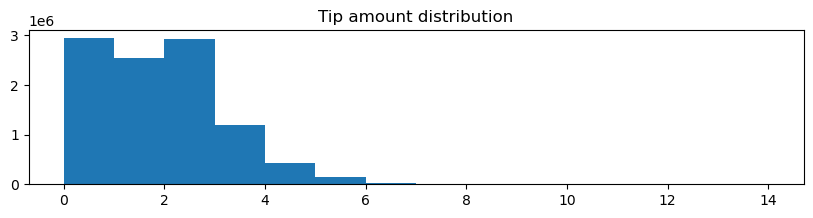

In [58]:
plt.figure(figsize=(10,2))
plt.hist(taxi_filtered_df['tip_amount'], bins=range(0,15))
plt.title('Tip amount distribution')
plt.show()

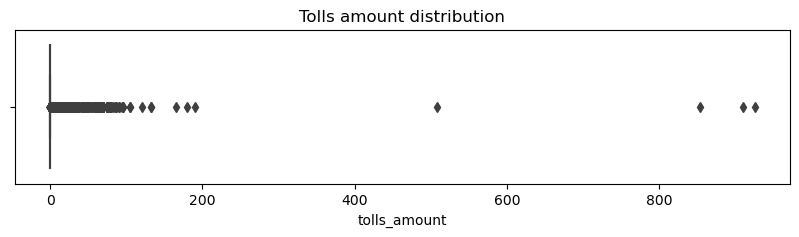

In [59]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['tolls_amount'])
plt.title('Tolls amount distribution')
plt.show()

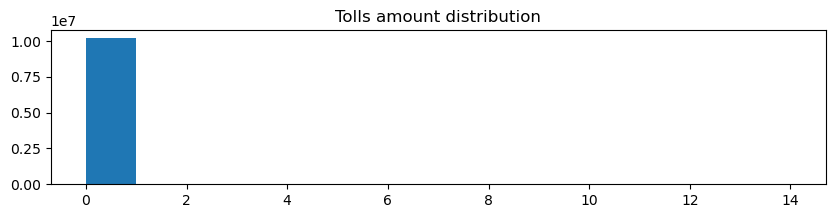

In [60]:
plt.figure(figsize=(10,2))
plt.hist(taxi_filtered_df['tolls_amount'], bins=range(0,15))
plt.title('Tolls amount distribution')
plt.show()

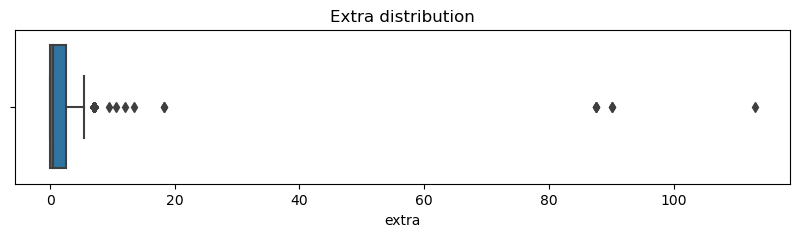

In [61]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['extra'])
plt.title('Extra distribution')
plt.show()

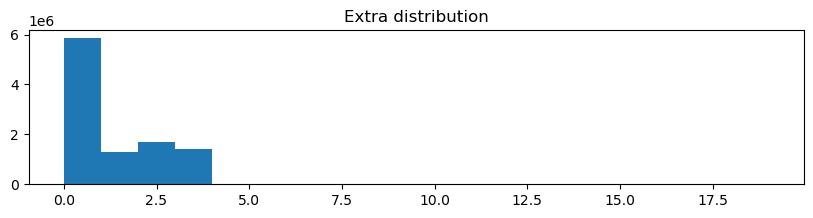

In [62]:
plt.figure(figsize=(10,2))
plt.hist(taxi_filtered_df['extra'], bins=range(0,20))
plt.title('Extra distribution')
plt.show()

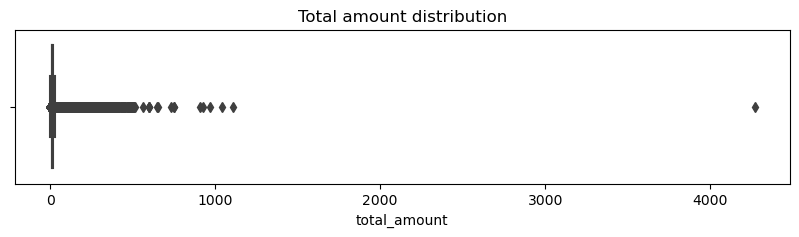

In [63]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['total_amount'])
plt.title('Total amount distribution')
plt.show()

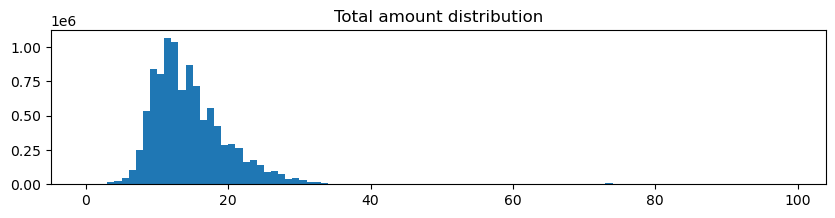

In [64]:
plt.figure(figsize=(10,2))
plt.hist(taxi_filtered_df['total_amount'], bins=range(0,100))
plt.title('Total amount distribution')
plt.show()

After seeing how data is distributed we are going to work on outliers as before and we will see how data looks afterwards.

This time we are going to set a threshold on total amount. We will use 100 dollars as threshold as after doing some research we have seen that for trips between Manhattan to JFK Airport, there's a flat fare of $70, plus tolls and potential surchages. NYC is one of the most visited cities in the world and the trip to Manhattan to the airport or viceversa can be something usual.

As previously we are going to begin with total amount.

In [65]:
total_amount_threshold = 100

taxi_filtered_df = taxi_filtered_df[taxi_filtered_df['total_amount']<= total_amount_threshold]

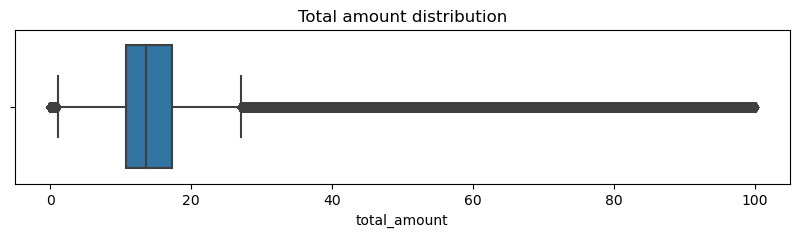

In [66]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['total_amount'])
plt.title('Total amount distribution')
plt.show()

After working on total amount we want to know how max and min values changed in the other features. With this information and a visualization we can get some clue of what to do next with them. We are aslo going to work on them based on the percentage they represent from the total amount total. This percentage also give a tip of if it is worth it to work on the features or not.

In [67]:
print('Min fare amount :' , taxi_filtered_df['fare_amount'].min())
print('Max fare amount :' , taxi_filtered_df['fare_amount'].max())
print('% from total amount: ', round((taxi_filtered_df['fare_amount'].sum()/taxi_filtered_df['total_amount'].sum())*100,2), '%')
print()
print('Min extra :' , taxi_filtered_df['extra'].min())
print('Max extra :' ,taxi_filtered_df['extra'].max())
print('% from total amount: ', round((taxi_filtered_df['extra'].sum()/taxi_filtered_df['total_amount'].sum())*100,2), '%')
print()
print('Min mta tax :' , taxi_filtered_df['mta_tax'].min())
print('Max mta tax :' ,taxi_filtered_df['mta_tax'].max())
print('% from total amount: ', round((taxi_filtered_df['mta_tax'].sum()/taxi_filtered_df['total_amount'].sum())*100,2), '%')
print()
print('Min tip amount :' , taxi_filtered_df['tip_amount'].min())
print('Max tip amount :' ,taxi_filtered_df['tip_amount'].max())
print('% from total amount: ', round((taxi_filtered_df['tip_amount'].sum()/taxi_filtered_df['total_amount'].sum())*100,2), '%')
print()
print('Min tolls amount :' , taxi_filtered_df['tolls_amount'].min())
print('Max tolls amount :' ,taxi_filtered_df['tolls_amount'].max())
print('% from total amount: ', round((taxi_filtered_df['tolls_amount'].sum()/taxi_filtered_df['total_amount'].sum())*100,2), '%')
print()


Min fare amount : 0.0
Max fare amount : 100.0
% from total amount:  64.29 %

Min extra : 0.0
Max extra : 18.35
% from total amount:  7.25 %

Min mta tax : 0.0
Max mta tax : 39.51
% from total amount:  3.34 %

Min tip amount : 0.0
Max tip amount : 97.0
% from total amount:  12.06 %

Min tolls amount : 0.0
Max tolls amount : 90.0
% from total amount:  0.19 %



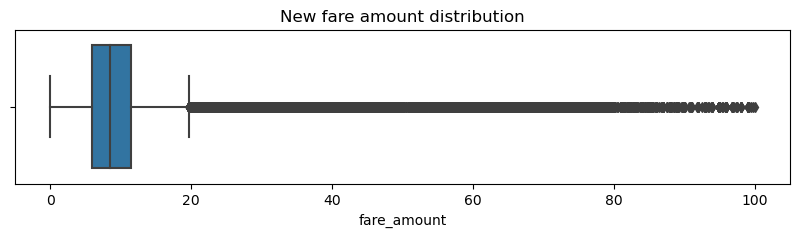

In [68]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['fare_amount'])
plt.title('New fare amount distribution')
plt.show()

Fare amount represent around 64% of the total amount charged to customers. We can see that after the filtering previously done into total amount, this feature also has a maximun of $100. 

As it represents a high percentage of the total amount and there are fares that may be due to some fixed trips we are going to keep it like it is.

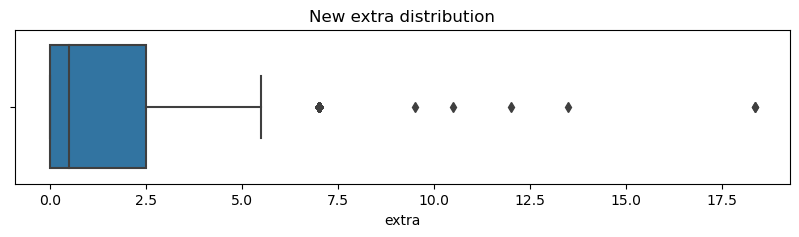

In [69]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['extra'])
plt.title('New extra distribution')
plt.show()

In [70]:
# quantile 0.25
percentile_25 = taxi_filtered_df['extra'].quantile(0.25)
print('Percintile 25%: ', percentile_25)

# quantile 0.75
percentile_75 = taxi_filtered_df['extra'].quantile(0.75)
print('Percintile 75%: ', percentile_75)

# IQR 
iqr = round(percentile_75 - percentile_25, 2) 
print('IQR: ', iqr)

# upper limit
upper_limit = percentile_75 + 1.5 * iqr
print('Upper limit: ', upper_limit)

print('Extra above upper limit:',len(taxi_filtered_df[taxi_filtered_df['extra']>upper_limit]), 'rows')

Percintile 25%:  0.0
Percintile 75%:  2.5
IQR:  2.5
Upper limit:  6.25
Extra above upper limit: 724 rows


Extra is defined as miscellaneous extras and surcharges. It represent 7.25% of the total amount charged to customers but out of the full data set extra charged above the upper limit of the feature not even represent 1% of data.  

Also as defined before, extra can represent legitimate but rare events so we will keep them too.

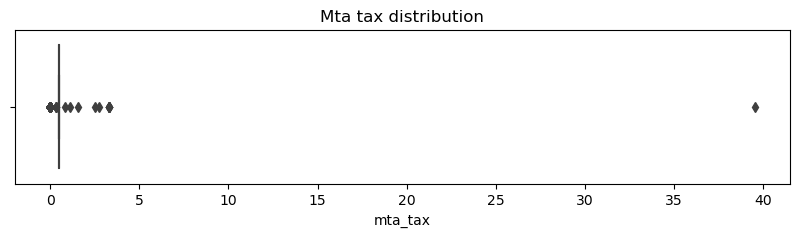

In [71]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['mta_tax'])
plt.title('Mta tax distribution')
plt.show()

In [72]:
print('MTA tax different from 0.50:' ,len(taxi_filtered_df[taxi_filtered_df['mta_tax']!=0.5]), 'rows')
print('MTA tax % different from 0.5 respect MTA tax total length:', round(len(taxi_filtered_df[taxi_filtered_df['mta_tax']!=0.5])/len(taxi_filtered_df['mta_tax']),5)*100,'%')

MTA tax different from 0.50: 37535 rows
MTA tax % different from 0.5 respect MTA tax total length: 0.365 %


'mta_tax' only represent 3.34% of the total amount but it is defined as '$0.50 MTA tax that is automatically triggered based on the metered rate in use'. 

Following the definition we should only have 'mta_tax' equal to 0.5 a trip only has one fare that can trigger or not the tax.
We will drop this values

In [73]:
taxi_filtered_df = taxi_filtered_df[taxi_filtered_df['mta_tax']==0.5]
taxi_filtered_df.shape

(10244528, 20)

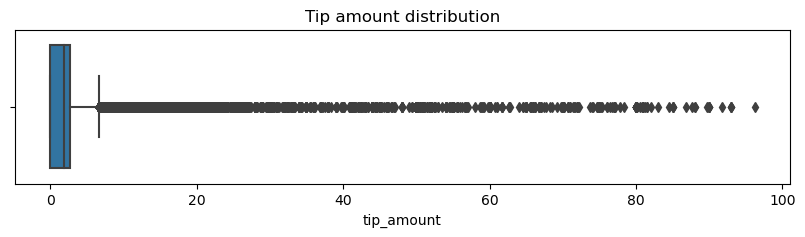

Tip median: 1.86


In [74]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['tip_amount'])
plt.title('Tip amount distribution')
plt.show()

print('Tip median:',taxi_filtered_df['tip_amount'].median())

Tips are choosen by customers so we wont touch it. Working on the negative values made sense but whatever quantity is given by the customer is their choice. There may be some wrong data entries but as looking at the distribution, the majority of them are around $1.86, we will take all of them as good.

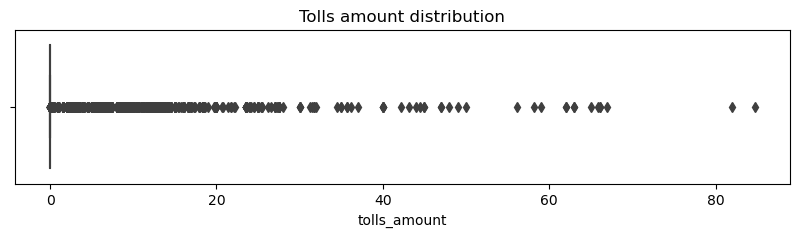

In [75]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['tolls_amount'])
plt.title('Tolls amount distribution')
plt.show()

In [76]:
taxi_filtered_df['tolls_amount'].value_counts(normalize=True).head()

tolls_amount
0.00     0.995928
6.12     0.003708
11.75    0.000061
2.50     0.000045
2.80     0.000044
Name: proportion, dtype: float64

In [77]:
len(taxi_filtered_df[taxi_filtered_df['tolls_amount']>=1.25])

41575

Tolls represent 0.19% of total amount charged to a customer. Taking into account this small amount we think that it wont make any difference when predicting the future total amount but seeing the distribution there are some strange values that we think we can drop to have a better data set.

After a brief research we have concluded that customers pay $1.25 for each trip to, from, within, or through the Congestion Relief Zone in the city of New York.

Also if we look at the distribution of the dataset, 99% percent of the trips aren't charged for tolls.

Based on these analysis, we will drop the rows that have a toll amount higher than $1.25. A total of 41575 rows

In [78]:
taxi_filtered_df = taxi_filtered_df[taxi_filtered_df['tolls_amount']<1.25]
taxi_filtered_df.shape

(10202953, 20)

In [79]:
taxi_filtered_df.describe(include='all')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,tpep_pickup_year,dif_pickup_dropoff_mins
count,10202953,10202953,10202953,1.020295e+07,1.020295e+07,1.020295e+07,10202953,1.020295e+07,1.020295e+07,1.020295e+07,1.020295e+07,1.020295e+07,10202953.0,1.020295e+07,1.020295e+07,1.020295e+07,1.020295e+07,1.020295e+07,10202953.0,1.020295e+07
unique,2,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,6927826,NaN,NaN,NaN,NaN,NaN,10101325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2020-01-30 02:18:09.121440,2020-01-30 02:31:40.407873536,1.538796e+00,1.748366e+00,1.009914e+00,NaN,1.670328e+02,1.654107e+02,1.257293e+00,9.376257e+00,1.084042e+00,0.5,1.767591e+00,6.390307e-06,2.999317e-01,1.464894e+01,2.378655e+00,2020.0,1.352144e+01
min,NaN,2020-01-01 00:00:00,2020-01-01 00:01:57,1.000000e+00,0.000000e+00,1.000000e+00,NaN,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.5,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,2020.0,-2.860967e+03
25%,NaN,2020-01-16 09:21:31,2020-01-16 09:37:35,1.000000e+00,9.000000e-01,1.000000e+00,NaN,1.250000e+02,1.140000e+02,1.000000e+00,6.000000e+00,0.000000e+00,0.5,0.000000e+00,0.000000e+00,3.000000e-01,1.080000e+01,2.500000e+00,2020.0,6.066667e+00
50%,NaN,2020-01-30 10:24:09,2020-01-30 10:39:24,1.000000e+00,1.420000e+00,1.000000e+00,NaN,1.630000e+02,1.630000e+02,1.000000e+00,8.500000e+00,5.000000e-01,0.5,1.860000e+00,0.000000e+00,3.000000e-01,1.356000e+01,2.500000e+00,2020.0,9.600000e+00
75%,NaN,2020-02-12 18:44:53,2020-02-12 18:58:12,2.000000e+00,2.300000e+00,1.000000e+00,NaN,2.340000e+02,2.340000e+02,2.000000e+00,1.150000e+01,2.500000e+00,0.5,2.660000e+00,0.000000e+00,3.000000e-01,1.725000e+01,2.500000e+00,2020.0,1.441667e+01
max,NaN,2020-07-31 18:50:41,2020-07-31 18:54:12,9.000000e+00,5.780000e+00,9.900000e+01,NaN,2.650000e+02,2.650000e+02,4.000000e+00,9.916000e+01,1.835000e+01,0.5,9.620000e+01,1.100000e+00,3.000000e-01,1.000000e+02,2.750000e+00,2020.0,5.549917e+03


Taking a last look to the data we have to work on 'dif_pickup_dropoff_mins'. It has negative values and really large ones.
First we will dropp negative values as they seem to be wrong entries and then we will handle large values. To do this we are going to look at the distribution and also to other features to mark a threshold. We want to identify if there is data with really large values in 'dif_pickup_dropoff_mins' and very short 'trip_distance' or 'total_amount'.

In [80]:
#checking how much data is in 'dif_pickup_dropoff_mins' has negative values
print('Number of rows with negative values:', len(taxi_filtered_df[taxi_filtered_df['dif_pickup_dropoff_mins']<0]))

Number of rows with negative values: 2


In [81]:
# visualizing the 2 rows to see why they have negatives values
taxi_filtered_df[taxi_filtered_df['dif_pickup_dropoff_mins']<0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,tpep_pickup_year,dif_pickup_dropoff_mins
541143,1,2020-01-04 08:19:55,2020-01-02 10:09:33,1,3.5,1,N,107,237,1,16.5,2.5,0.5,4.95,0.0,0.3,24.75,2.5,2020,-2770.366667
7359171,1,2020-02-05 16:28:03,2020-02-03 16:47:05,1,1.2,1,N,236,262,1,8.0,3.5,0.5,3.65,0.0,0.3,15.95,2.5,2020,-2860.966667


This two rows appear to be wrong entries as datetime for dropp off is sooner than pickup. 

In [82]:
# dropping values and setting a new data set
taxi_filtered_df = taxi_filtered_df[taxi_filtered_df['dif_pickup_dropoff_mins']>=0]

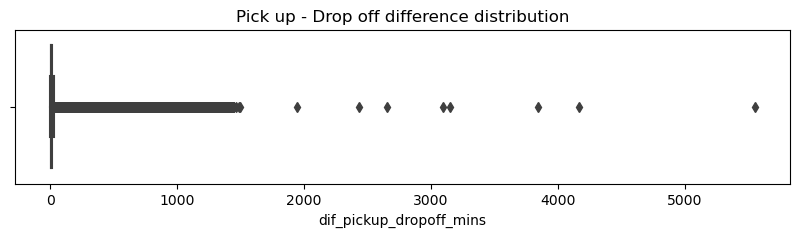

In [83]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['dif_pickup_dropoff_mins'])
plt.title('Pick up - Drop off difference distribution')
plt.show()

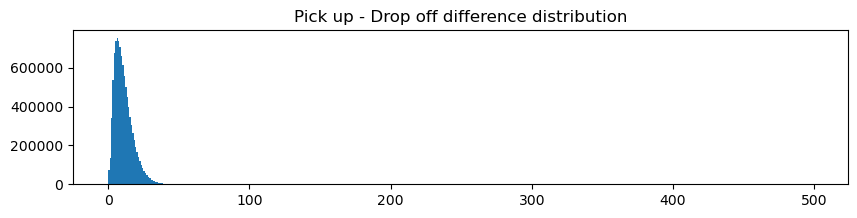

In [84]:
plt.figure(figsize=(10,2))
plt.hist(taxi_filtered_df['dif_pickup_dropoff_mins'], bins=range(0,500))
plt.title('Pick up - Drop off difference distribution')
plt.show()

There a many large values in the data for feature 'dif_pickup_dropoff_mins' whereas the percentile 75 is at 14.4 minutes of trip. 

As we have been assuming that there are fixed trips to airports for example we are also going to take into account the average minutes trip between New York City center and JFK International airport. After a quick research, the average trip is from 45 minutes to 1 hour. We are going to use 1 hour trip as we also want to take into account possible traffic jams or transportation issues that may occur.

In [85]:
# Setting 60 minutes as threshold
picku_dropoff_threshold = 60

print('Pickup-Drop off minutes above threshold:',len(taxi_filtered_df[taxi_filtered_df['dif_pickup_dropoff_mins']>picku_dropoff_threshold]), 'rows')
print()
print('Pick up-Drop off minutes difference percentage from total size:',
      round(
          (len(taxi_filtered_df[taxi_filtered_df['dif_pickup_dropoff_mins']>picku_dropoff_threshold])
           /len(taxi_filtered_df['dif_pickup_dropoff_mins']
               )
          ),3)*100, '%')       


Pickup-Drop off minutes above threshold: 22096 rows

Pick up-Drop off minutes difference percentage from total size: 0.2 %


In [86]:
# dropping values from datetime difference feature
taxi_filtered_df = taxi_filtered_df[taxi_filtered_df['dif_pickup_dropoff_mins']<= picku_dropoff_threshold]
taxi_filtered_df.shape

(10180855, 20)

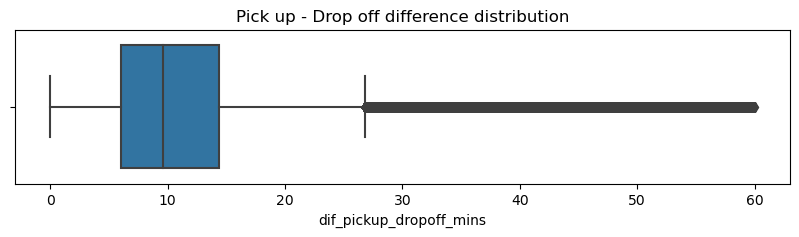

In [87]:
plt.figure(figsize=(10,2))
sns.boxplot(x= taxi_filtered_df['dif_pickup_dropoff_mins'])
plt.title('Pick up - Drop off difference distribution')
plt.show()

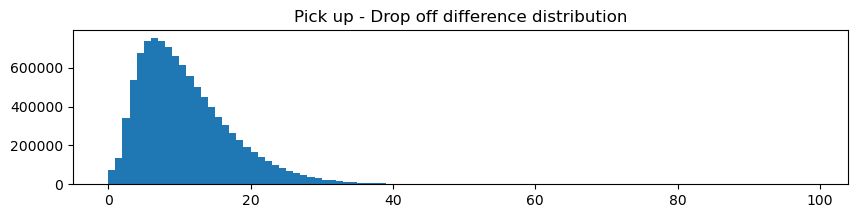

In [88]:
plt.figure(figsize=(10,2))
plt.hist(taxi_filtered_df['dif_pickup_dropoff_mins'], bins=range(0,100))
plt.title('Pick up - Drop off difference distribution')
plt.show()

Now 'dif_pickup_dropoff_mins' distribution has much more sense. We can see that most of the data is fitted around 10 minutes.  

Next and last step on data cleaning is review 'trip_distance' = 0. When we handled trip_distance feature we decided not to dropp rows equal to 0 as we thougth that working on other features could help and would lead to a better data set instead of dropping a large amount of data. 


In [89]:
# Checking how many rows are still trip_distance = 0
print('Total rows in data set with trip distance equal to zero:', len(taxi_filtered_df[taxi_filtered_df['trip_distance']==0]))

Total rows in data set with trip distance equal to zero: 73352


There are not many rows still with 'trip_distance' equal to zero if we look at the entire data set but we want to be as strict as possible so after doing some research we found an article from New York City Taxi and Limousine Commission where it says that for cancellation (main case we thought for trip distance being 0) customers are fee with $5 when driver has already driven for 0.5 miles.

We are going to take this fee as threshold to filter the data when trip distance is equal to zero.

In [90]:
fee_condition = taxi_filtered_df[(taxi_filtered_df['trip_distance']>=0.5) & (taxi_filtered_df['total_amount']==5)]
fee_condition.shape

(21, 20)

In [91]:
taxi_filtered_df.shape

(10180855, 20)

In [92]:
# creating last filtered dataframe
# 1. finding the number of rows to drop 
rows_to_drop = fee_condition.index
print(rows_to_drop)

Index([  796160,   916189,  1264627,  1986517,  2988627,  3195660,  3301482,
        4429295,  5342625,  5518023,  5537750,  5936510,  5942252,  6149926,
        6479767,  8809037,  9770935, 10519431, 10771612, 11144874, 11526173],
      dtype='int64')


In [93]:
# Dropping the rows from the original DataFrame
taxi_filtered_df.drop(rows_to_drop, inplace=True)


In [94]:
# Checking if dropped was made succesfully
taxi_filtered_df.shape

(10180834, 20)

We have concluded the first part of the EDA. It consisted in changing data types, cleaning missing, wrong data and handling outliers and giving the data set the desired structure.

As a matter of effeciency, we after doing the necessary changes and due to the large data set we are going to use a random sample of it to keep working. We are going to work with a 1% of the dataframe so it will consist on 100k rows approximatedly.


In [95]:
# Defining the sample size (1% of the data)
sample_size = int(0.01 * len(taxi_filtered_df))  

# Randomly sample the data (without replacement)
sampled_df = taxi_filtered_df.sample(sample_size, random_state=42)  # Set random_state for reproducibility
sampled_df.shape

(101808, 20)

In [96]:
sampled_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,tpep_pickup_year,dif_pickup_dropoff_mins
2777559,2,2020-01-15 10:25:38,2020-01-15 10:29:41,1,0.70,1,N,238,239,1,5.0,0.0,0.5,2.49,0.0,0.3,10.79,2.5,2020,4.050000
8291022,2,2020-02-09 16:01:24,2020-02-09 16:11:57,1,1.86,1,N,113,233,1,9.0,0.0,0.5,3.08,0.0,0.3,15.38,2.5,2020,10.550000
700007,1,2020-01-05 00:35:53,2020-01-05 00:48:39,2,1.70,1,N,249,79,1,10.0,3.0,0.5,2.75,0.0,0.3,16.55,2.5,2020,12.766667
9737381,1,2020-02-16 01:01:35,2020-02-16 01:05:58,1,0.40,1,N,48,246,2,4.5,3.0,0.5,0.00,0.0,0.3,8.30,2.5,2020,4.383333
8300307,2,2020-02-09 17:27:05,2020-02-09 17:47:00,1,3.03,1,N,43,230,2,15.0,0.0,0.5,0.00,0.0,0.3,18.30,2.5,2020,19.916667


1.0.3 Step 2.1 Data Exploration (Continue EDA) - FEATURE ENGINEERING

In [97]:
# Dropping columns we are not going to use
# 1. Creating a copy of the dataframe
model_df = sampled_df.copy()

# 2. Dropping columns
model_df = model_df.drop(columns=['VendorID', 'store_and_fwd_flag','extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge'])

In [98]:
# We are going to look at datetime features and split them into month, day and hour
model_df['pick_up_month'] = model_df['tpep_pickup_datetime'].dt.month
model_df['pick_up_day'] = model_df['tpep_pickup_datetime'].dt.day
model_df['pick_up_hour'] = model_df['tpep_pickup_datetime'].dt.hour

model_df['drop_off_month'] = model_df['tpep_dropoff_datetime'].dt.month
model_df['drop_off_day'] = model_df['tpep_dropoff_datetime'].dt.day
model_df['drop_off_hour'] = model_df['tpep_dropoff_datetime'].dt.hour


In [99]:
# We drop 'tpep_pickup_datetime' and 'tpep_dropoff_datetime' and 'tpep_pickup_year'.
# We drop year column as we are just working with 2020 data
model_df = model_df.drop(columns=['tpep_pickup_datetime','tpep_dropoff_datetime', 'tpep_pickup_year'])

In [100]:
print('PULocationID unique categories:', model_df['PULocationID'].nunique())
print('DOLocationID unique categories:', model_df['DOLocationID'].nunique())

PULocationID unique categories: 192
DOLocationID unique categories: 213


Given that we have two categorical variables with 192 possible categories each, one-hot encoding might lead to a high-dimensional dataset, making it computationally expensive and potentially prone to multicollinearity issues. In this scenario, frequency encoding could be a reasonable choice as it reduces the dimensionality while preserving the information about the relative importance of each category.

In [101]:
# frequency encoding PULocationID and DOLocationID
frequency_map = model_df['PULocationID'].value_counts(normalize=True)

model_df['pulocationid'] = model_df['PULocationID'].map(frequency_map)

frequency_map = model_df['DOLocationID'].value_counts(normalize=True)

model_df['dolocationid'] = model_df['DOLocationID'].map(frequency_map)

In [102]:
# dropping 'PULocationID' and 'DOLocationID' columns
model_df = model_df.drop(columns=['PULocationID','DOLocationID'])

In [103]:
model_df.head()

,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,tip_amount,total_amount,dif_pickup_dropoff_mins,pick_up_month,pick_up_day,pick_up_hour,drop_off_month,drop_off_day,drop_off_hour,pulocationid,dolocationid
2777559,1,0.70,1,1,5.0,2.49,10.79,4.050000,1,15,10,1,15,10,0.022248,0.028249
8291022,1,1.86,1,1,9.0,3.08,15.38,10.550000,2,9,16,2,9,16,0.016040,0.014979
700007,2,1.70,1,1,10.0,2.75,16.55,12.766667,1,5,0,1,5,0,0.021658,0.023780
9737381,1,0.40,1,2,4.5,0.00,8.30,4.383333,2,16,1,2,16,1,0.030960,0.022965
8300307,1,3.03,1,2,15.0,0.00,18.30,19.916667,2,9,17,2,9,17,0.015853,0.031451


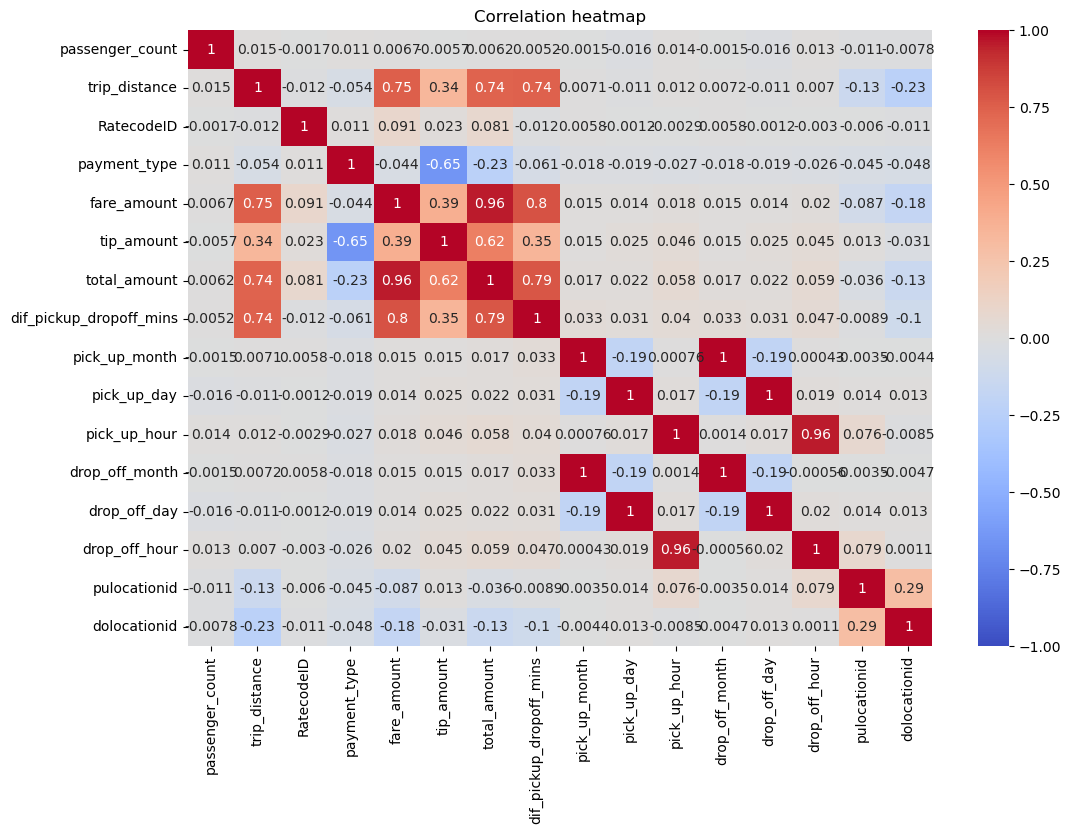

In [104]:
# Checking features correlation
model_df.corr(method='pearson')
# Building the visulization (corrlation heatmap)
plt.figure(figsize=(12,8))
sns.heatmap(model_df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()


1.0.4 Step 3 Model Building

According to the correlation heatmap we have strong multicollinearity between some varaibles. As our challenge is compare total amount predictions between a multiple regression model and a gradient boosting one we are going to work with different datasets.

Why? Basically because multiple linear regression model can be affected by multicollinearity much more than a XGBoost model (the one we going to use to compare) and also, XGBoost do not need to normalize features whereas a multiple linear regression model does.

From now the plan will be:

- Multiple regression model: 
    1. Make a copy of model_df and call it multi_regression_df
    2. Normalize features with a strong multicollinearity
    3. Evaluate result with another correlation heatmap and decide what features to include.
    4. Create and evaluate the model
    
- XGBoost model: 
    1. Make a copy of model_df and call it xgb_model_df
    2. Select features for the model.
    3. Create and evaluate the model

In [105]:
# Multiple regression model
# 1. Make a copy of model_df and call it multi_regression_df
multi_regression_df = model_df.copy()

In [106]:
# 1. Normalize features with strong multicollinearity --> 
# trip distance, fare amount, dif_pickup_dropoff_mins, pick_up_hour, drop_off_hour and tip_amount
def min_max_normalization(data):
    """
    Perform min-max normalization on the input data.
    
    Parameters:
    data (array-like): Input data to be normalized.
    
    Returns:
    normalized_data (array-like): Normalized data.
    """
    # Calculate the minimum and maximum values of the data
    min_val = np.min(data)
    max_val = np.max(data)
    
    # Perform min-max normalization
    normalized_data = (data - min_val) / (max_val - min_val)
    
    return normalized_data


In [107]:
multi_regression_df['normalize_trip_distance']= min_max_normalization(multi_regression_df['trip_distance'])
multi_regression_df['normalize_fare_amount']= min_max_normalization(multi_regression_df['fare_amount'])
multi_regression_df['normalize_dif_pickup_dropoff_mins']= min_max_normalization(multi_regression_df['dif_pickup_dropoff_mins'])
multi_regression_df['normalize_pick_up_hour']= min_max_normalization(multi_regression_df['pick_up_hour'])
multi_regression_df['normalize_drop_off_hour']= min_max_normalization(multi_regression_df['drop_off_hour'])
multi_regression_df['normalize_tip_amount']= min_max_normalization(multi_regression_df['tip_amount'])

In [108]:
multi_regression_df = multi_regression_df.drop(columns=['trip_distance','fare_amount','dif_pickup_dropoff_mins','pick_up_hour','drop_off_hour','tip_amount'])

In [109]:
multi_regression_df.head()

,passenger_count,RatecodeID,payment_type,total_amount,pick_up_month,pick_up_day,drop_off_month,drop_off_day,pulocationid,dolocationid,normalize_trip_distance,normalize_fare_amount,normalize_dif_pickup_dropoff_mins,normalize_pick_up_hour,normalize_drop_off_hour,normalize_tip_amount
2777559,1,1,1,10.79,1,15,1,15,0.022248,0.028249,0.121107,0.055556,0.067538,0.434783,0.434783,0.026774
8291022,1,1,1,15.38,2,9,2,9,0.016040,0.014979,0.321799,0.100000,0.175931,0.695652,0.695652,0.033118
700007,2,1,1,16.55,1,5,1,5,0.021658,0.023780,0.294118,0.111111,0.212896,0.000000,0.000000,0.029570
9737381,1,1,2,8.30,2,16,2,16,0.030960,0.022965,0.069204,0.050000,0.073096,0.043478,0.043478,0.000000
8300307,1,1,2,18.30,2,9,2,9,0.015853,0.031451,0.524221,0.166667,0.332129,0.739130,0.739130,0.000000


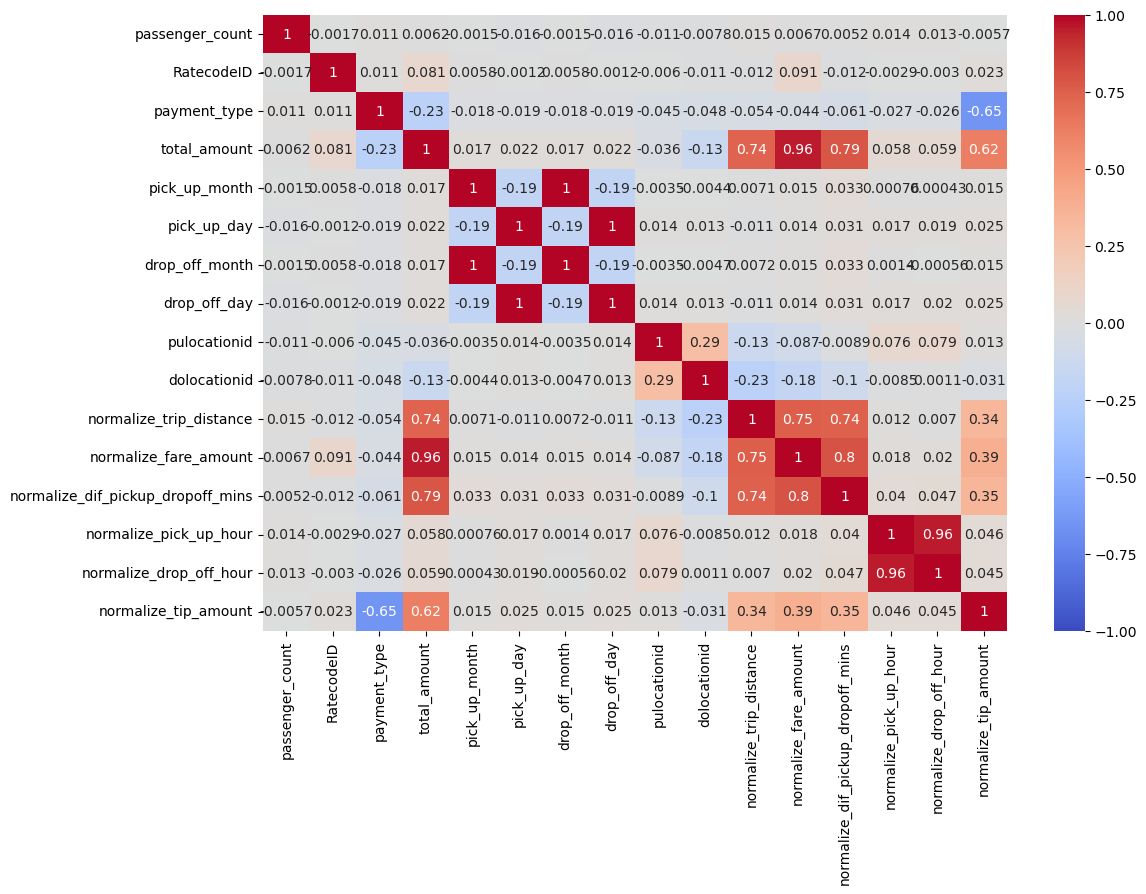

In [110]:
# 2. Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(multi_regression_df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.show()

In [111]:
# 3. Evaluate result with another correlation heatmap and decide what features to include.
# There are no major changes so are going to choose the columns for the multiple regression model.
# Multiple regression model predictor values --> All except trip_distance_normalize, normalize_dif_pickup_dropoff_mins and normalize_pick_up_hour
# Isolating predictor variable
X = multi_regression_df.drop(columns=['total_amount','normalize_trip_distance','normalize_dif_pickup_dropoff_mins','normalize_pick_up_hour'])

In [112]:
# Isolating target variable 
y = multi_regression_df['total_amount']

In [113]:
# Performing train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

In [114]:
X_train.head()

,passenger_count,RatecodeID,payment_type,pick_up_month,pick_up_day,drop_off_month,drop_off_day,pulocationid,dolocationid,normalize_fare_amount,normalize_drop_off_hour,normalize_tip_amount
2513445,1,1,2,1,14,1,14,0.007956,0.028249,0.083333,0.217391,0.000000
2345105,1,1,1,1,13,1,13,0.004086,0.031284,0.327778,0.391304,0.023656
5521252,2,1,1,1,28,1,28,0.038641,0.045085,0.072222,0.608696,0.012903
11181528,1,1,1,2,23,2,23,0.003674,0.001365,0.166667,0.434783,0.033978
7303963,1,1,2,2,5,2,5,0.036323,0.017268,0.050000,0.478261,0.000000


In [115]:
# Instantiating and fitting the training data.
lr = LinearRegression()
lr.fit(X_train, y_train)



LinearRegression()

In [116]:
# Evaluating the model performance on the training data
r_sq = lr.score(X_train, y_train)
print('Coefficient of determination:', r_sq)
y_pred_train = lr.predict(X_train)
print('R^2:', r2_score(y_train, y_pred_train))
print('MAE:', mean_absolute_error(y_train, y_pred_train))
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))

Coefficient of determination: 0.9882446872625426
R^2: 0.9882446872625426
MAE: 0.41441219461420575
MSE: 0.37269589914874274
RMSE: 0.6104882465279268


In [117]:
# Evaluating the model performance on the testing data
r_sq_test = lr.score(X_test, y_test)
print('Coefficient of determination:', r_sq_test)
y_pred_test = lr.predict(X_test)
print('R^2:', r2_score(y_test, y_pred_test))
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))

Coefficient of determination: 0.9877870600169704
R^2: 0.9877870600169704
MAE: 0.4154441037574915
MSE: 0.3717409040295244
RMSE: 0.6097055879927004


For the test data, a R2 of 0.9877 means that 98.77% of the variance in the total_amount variable is
described by the model.

In [118]:
# Creating a `results` dataframe
results = pd.DataFrame(data={'actual': y_test,
'predicted': y_pred_test.ravel()})
results['residual'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residual
704731,15.95,15.237692,0.712308
3878875,9.96,10.238859,-0.278859
4411518,15.80,15.568397,0.231603
3783930,8.16,9.575701,-1.415701
4264494,7.30,9.479682,-2.179682


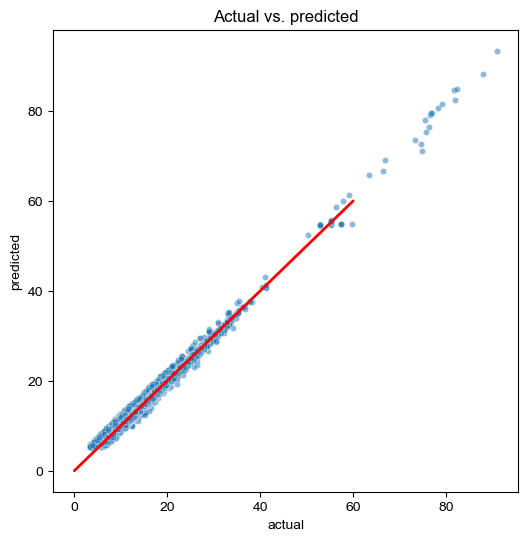

In [119]:
# Creating a scatterplot to visualize `predicted` over `actual`
fig, ax = plt.subplots(figsize=(6, 6))
sns.set(style='whitegrid')
sns.scatterplot(x='actual',y='predicted',data=results,s=20,alpha=0.5,ax=ax)
#Drawing an x=y line to show what the results would be if the model were perfect
plt.plot([0,60], [0,60], c='red', linewidth=2)
plt.title('Actual vs. predicted');

The scatter plot suggests a positive relationship between predicted and actual values, indicating the model is capturing the general trend. However, there is also some scattering around the line, implying the model's predictions are not always perfectly accurate.

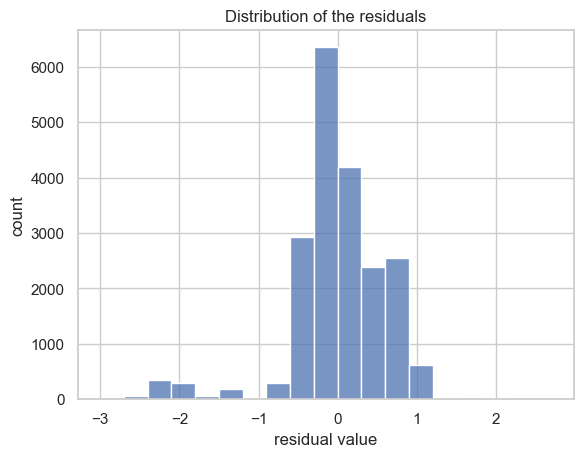

In [120]:
# Visualize the distribution of the `residuals`
sns.histplot(results['residual'], bins=np.arange(-3,3,0.3))
plt.title('Distribution of the residuals')
plt.xlabel('residual value')
plt.ylabel('count');

The visualized distribution of residuals suggests that they might be following a normal distribution, which is a good sign for the validity of the linear regression model. However, it's advisable to perform additional tests and consider the sample size for a more robust analysis as there are some outliers in the negative side of the distribution. 

We will perform a Shapiro-Wilk test with a 0.05 significance level.

We will have a hypothesis as: 
    - Ho: Distribution of residuals does not follows a normal distribution
    - H1: Distribution of residuals follows a normal distribution

In [121]:
# Shapiro-Wilk Test
shapiro_test = stats.shapiro(results['residual'])
shapiro_stat, shapiro_pvalue = shapiro_test

# Print the test results
print("Shapiro-Wilk Test Statistic:", shapiro_stat)
print("Shapiro-Wilk p-value:", shapiro_pvalue)

Shapiro-Wilk Test Statistic: 0.8801709413528442
Shapiro-Wilk p-value: 0.0


C:\Users\Usuario\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


As Shapiro-Wilk p-value = 0.0 we reject the null hypothesis, the distribution of the residuals does not follow a normal distribution.
This does not indicate that the model is not valid.  As the dataset is very large, the impact of non-normality on p-values can be mitigated. The Central Limit Theorem suggests that even with non-normal data, the distribution of the estimated coefficients tends to be normal for large samples.

We can look at the results from the model as R^2 to see if the model is well fitted. In our case R^2 is 0.9877.

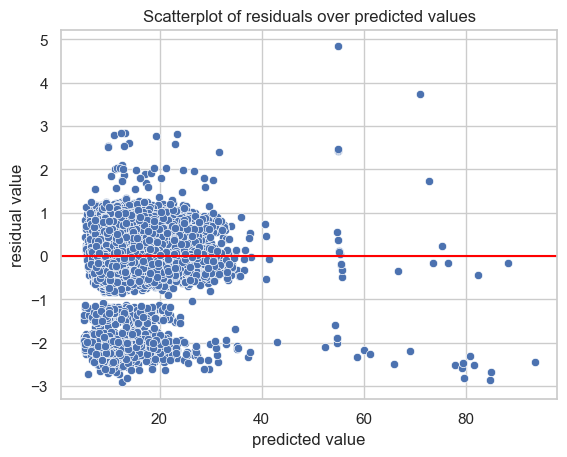

In [122]:
# Create a scatterplot of `residuals` over `predicted`
sns.scatterplot(x='predicted', y='residual', data=results)
plt.axhline(0, c='red')
plt.title('Scatterplot of residuals over predicted values')
plt.xlabel('predicted value')
plt.ylabel('residual value')
plt.show()

The scatter plot of residuals vs. predicted values suggests a positive correlation between predicted and actual values, with some variability in prediction errors. This aligns with the observations from the previous scatter plot (predicted vs. actuals) and the distribution of residuals.

Data points deviated from the zero line represents the prediction error for that particular instance. There are some data points above and below the zero line, indicating both overprediction (positive residuals) and underprediction (negative residuals) by the model.

In [123]:
# Getting model coefficients
coefficients = pd.DataFrame(lr.coef_, columns=['Coefficients'])

# Assign column names from X.columns to the DataFrame
coefficients.index = X.columns

# Display the DataFrame
print(coefficients)

                         Coefficients
passenger_count              0.010308
RatecodeID                  -0.017210
payment_type                -0.071797
pick_up_month              -19.226804
pick_up_day                 -0.617440
drop_off_month              19.231598
drop_off_day                 0.618390
pulocationid                11.398779
dolocationid                 8.706394
normalize_fare_amount       89.699949
normalize_drop_off_hour      0.617717
normalize_tip_amount        96.637367


From all the features we have considered to predict the total amount we can see that fare amount and tip amount are the most impactfull ones. 
In this case as we used normalized data, the interpretation would be that for every one standard deviation fare amount increases, total amount would increase 89.699. Same would be with all the normalize features.

If we would want to see how would the total amount change taking into account the original units from the normalized values, we would have to renormalize the features using revers normalization.


As we have used a min-max normalization, this would be the steps:

In [124]:
# normalize_fare_amount and normalize_tip_amount 
# calculate std from normalize_fare_amount in the train data set
print('Normalize_fare_amount std: ',X_train['normalize_fare_amount'].std())
print()
# calculate std from normalize_tip_amount  in the train data set
print('Normalize_tip_amount std: ',X_train['normalize_tip_amount'].std())
print()
# Divide the normalized value by the std
print('Denormalized value for fare amount:', coefficients.loc['normalize_fare_amount','Coefficients']*X_train['normalize_fare_amount'].std())
print()
print('Denormalized value for tip amount:', coefficients.loc['normalize_tip_amount','Coefficients']*X_train['normalize_tip_amount'].std())

Normalize_fare_amount std:  0.053299965109969594

Normalize_tip_amount std:  0.016639814061507618

Denormalized value for fare amount: 4.781004146774839

Denormalized value for tip amount: 1.6080278225837168


After reverse normalizing we have fare_amount values again into dollars. In the case we can say that for every dollar increased in fare amount, the total amount would increase in 4.781 dollars and for every dollar increased in tip amount the total amount would increase in $1.60 always taking into account that all the other features remaing equal.

In [125]:
# Gradient boosting 
# 1. Make a copy of model_df and call it multi_regression_df
xgb_model_df = model_df.copy()

In [126]:
# 2. Select features and 3. build the model
# Isolating predictor variable
X = xgb_model_df.drop(columns=['total_amount'])
# Isolating target variable 
y = xgb_model_df['total_amount']

In [127]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

In [128]:
# Initializing the XGBRegressor model
xgb_model = XGBRegressor()

In [129]:
# Defining a grid of hyperparameters
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 4, 6],
    'n_estimators': [50, 150, 300],
    'min_child_weight': [5,10]
}

In [130]:
# Initializing GridSearchCV with the XGBoost regressor model and parameter grid
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='r2', cv=5)


In [131]:
%%time
# Fittin the GridSearchCV object to the training data
xgb_grid.fit(X_train, y_train)

CPU times: total: 16min 28s
Wall time: 1min 32s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [2, 4, 6], 'min_child_weight': [5, 10],
                         'n_estimators': [50, 150, 300]},
             scoring='r2')

In [132]:
# Getting the best parameters and best estimator found by GridSearchCV
best_params = xgb_grid.best_params_
best_estimator = xgb_grid.best_estimator_
best_score = xgb_grid.best_score_
print(best_params)
print()
print(best_estimator)
print()
print(best_score)

{'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 300}

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

0.9915891062191218


In [133]:
# Making predictions on the test data using the best estimator
y_pred = best_estimator.predict(X_test)

In [134]:
# Evaluation of the model.
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print()
print('R2:', r2)


Mean Squared Error: 0.11847426658519614

R2: 0.9961077215564539


The MSE value of approximately 0.118 indicates that, on average, the model's predictions have a squared error of 0.118, which is relatively low and suggests good predictive accuracy.
The R-squared value of approximately 0.996 indicates that the model explains approximately 99.6% of the variance in the target variable, which is very high and suggests that the model provides an excellent fit to the data.

In [135]:
# Accessing the feature importances of the best estimator
feature_importances = best_estimator.feature_importances_

# Creating a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sorting the DataFrame by importance values (descending)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(importance_df)


                    Feature  Importance
4               fare_amount    0.887621
5                tip_amount    0.082310
13             pulocationid    0.006423
9              pick_up_hour    0.004932
14             dolocationid    0.003667
12            drop_off_hour    0.003013
7             pick_up_month    0.002884
2                RatecodeID    0.002819
8               pick_up_day    0.001748
1             trip_distance    0.001493
6   dif_pickup_dropoff_mins    0.001407
11             drop_off_day    0.000702
3              payment_type    0.000399
0           passenger_count    0.000379
10           drop_off_month    0.000203


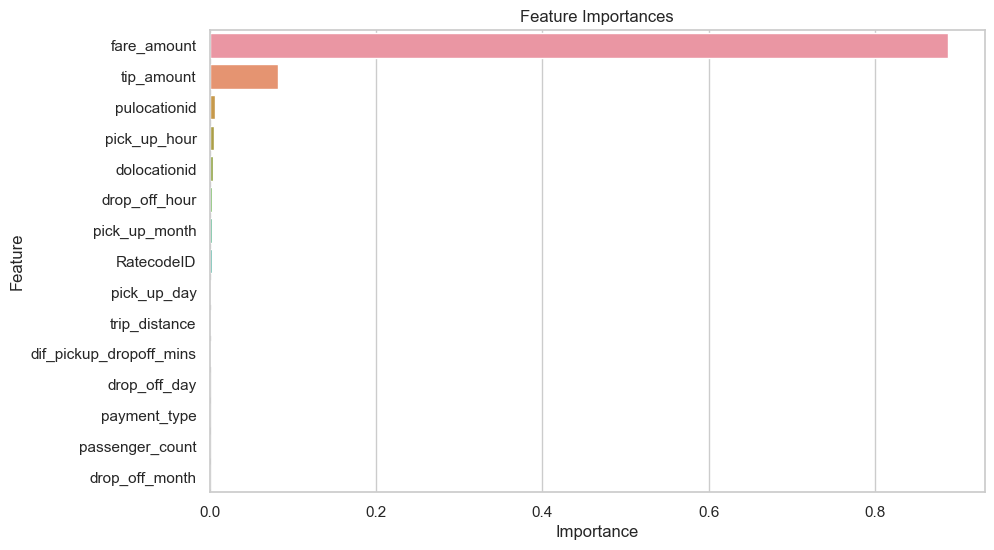

In [136]:
# Plot feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

Gradient boosting model give us the same conclusion as the multiple regression model; fare amount and tip amount are the most important features. However for xgboost model, fare amount is much more important. 

As a conclusion, it appears that both models are good. Both R^2 values are really high, meaning that the predictor features explained very good the predicted features. 
It's true that multiple linear regression model has some deficiencies as it appears that residual does not follow a normal distruibution and there is a group of points on the residuals over the predicted values that do not follow the expectations.

It is difficult to choose one model between the two of them as multiple linear regression model has easier and more understandable coefficients and is much more straight forward when trying to predict the price whereas xgboost seem to be a more robust model but not as easy to understand.

In this case, as the goal of the project was only to compare both model accuracy and readibility we wont chose one but if we would have to, we would focus on what would be the latest goal. Maybe if we woud want to predict values of the prices and try to present numbers we would chose the multiple linear regression model but if the main goal would be understand how predictor features affect the predicted variables, we would choose gradient boosting model.